# Experimenting with the Twitter package `tweepy`

For now, basic things will be carried out such as finding the attributes of the people we follow, post something, send a direct message... Things like that.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tweepy

#Inline plots:
%matplotlib inline

#Beautiful R-like plots:
plt.style.use('ggplot')

#Start twitter
Codes=pickle.load(open(PRIVATE CREDENTIALS,'rb'))

auth = tweepy.OAuthHandler(Codes['Consumer Key'], Codes['Consumer Secret'])
auth.set_access_token(Codes['Access Token'], Codes['Access Token Secret'])

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#FUNCTION TO TELL YOU THE AMOUNT OF REQUESTS LEFT UNTIL THE TIMER RESETS:
def test_rate_limit(api, wait=True, buffer=.1):
    from datetime import datetime
    import time
    """
    Tests whether the rate limit of the last request has been reached.
    :param api: The `tweepy` api instance.
    :param wait: A flag indicating whether to wait for the rate limit reset
                 if the rate limit has been reached.
    :param buffer: A buffer time in seconds that is added on to the waiting
                   time as an extra safety margin.
    :return: True if it is ok to proceed with the next request. False otherwise.
    """
    #Get the number of remaining requests
    remaining = int(api.last_response.headers['x-rate-limit-remaining'])
    #Check if we have reached the limit
    if remaining == 0:
        reset = int(api.last_response.headers['x-rate-limit-reset'])
        #Parse the UTC time
        reset = datetime.fromtimestamp(reset)
        
        #Let the user know we have reached the rate limit
        print("Limit reached until {}.".format(reset))
        
        #Determine the delay and sleep
        delay = (reset - datetime.now()).total_seconds() + buffer

        if wait & (delay>0):
            print("Sleeping for {:.2f} s...".format(delay))
            time.sleep(delay)
            #We have waited for the rate limit reset. OK to proceed.
            print('Ready to continue!')
        elif not wait:
            #We have reached the rate limit. The user needs to handle the rate limit manually.
            pass
    else:
        #We have not reached the rate limit
        print('Requests remaining: {}'.format(remaining))
    pass

## 1. Read the news feed
The following snipped finds the first 20 posts on my twitter feed and prints it in the notebook with a pretty display.

In [2]:
#Let's see the top tweets in my feed:
public_tweets = api.home_timeline()

#And print them pretty :D

structure = '{:^25} | {:50}'
print(structure.format('User', 'Tweet'))
print('='*80)
for tweet in public_tweets:
    user = tweet.user.name   #Name of the account. The screen_name is the username in @username.
    text = tweet.text.replace('\n','')
    print(structure.format(user,text[:50]))
    if len(text) > 50:
        print(structure.format('', tweet.text[50:100]))
        if len(text) > 100:
            print(structure.format('', text[100:]))

          User            | Tweet                                             
         Science          | Scientists give star treatment to lesser-known cel
                          | ls crucial for brain development https://t.co/hKLy
                          | SUQeuN https://t.co/SugsQcIBY1                    
         Science          | Moving beyond nudges to improve health and health 
                          | care policies https://t.co/Ldbou3G7Qd             
         Science          | Why teens take risks: It’s not a deficit in brain 
                          | development https://t.co/wRISJhY8yy               
         Science          | UMass Amherst researchers find ‘switch’ that  turn
                          | s on immune cells’ tumor-killing ability https://t
                          | .co/hHcoq3ZzlI https://t.co/4MccW1ndHy            
          Gabri           | RT @AdaColau: Amb @Cami_Cambrils, alcaldessa de Ca
                          | mbrils. Barcelona i Camb

## 2. Post a tweet
With the simple following tweet we can post any tweet we want.

In [3]:
#Let's put a regular tweet:
#tweetbonic = 'Coding is funnier when friends are around @QuantumBecky #fun #bigData #automaticSystems #TwitterFun!'
#if len(tweetbonic)>144:
#    print('False')
#else:
#    api.update_status(tweetbonic)

#Let's put a tweet with some image:
#import urllib.request as urllib
#URL = 'https://i.pinimg.com/736x/5c/97/c8/5c97c8c2afa2cde40aa6330266389d90--anime-meme-funny-dogs.jpg'
#file = urllib.urlretrieve(URL,'f.jpg')
#file = 'twitterConnect.png'
#tweetbonic = 'My Twitter connectome. Super proud of learning #python #networkx #tweepy #bigdata #webmining #coding #excited'
#if len(tweetbonic)>144:
#    print('False')
#else:
#    api.update_with_media(file, tweetbonic)

In [2]:
#Let's get our first 20 followers list and the people we follow:
#It is not very useful but it will be used to find the keys in
#the twitter objects so we know what to use later on :)!
followers = api.followers()
followed = api.friends()

In [5]:
#The keys that we can use with the followers and the people we follow are:
print('Keys for the USERS:\n{}'.format('='*110))
x = sorted(list(followers[0].__getstate__()['_json'].keys()))
lin = '{:^36} | {:^36} | {:^36}'
m = 3
for n,i in enumerate(x):
    if (n%m==0) & (n>0):
        a,b,c = x[n-m:n][0], x[n-m:n][1], x[n-m:n][2]
        print(lin.format(a,b,c))
    elif n == len(x)-1:
        print(lin.format(x[-2], x[-1], ''))
print('\nKeys for the POSTS:\n{}'.format('='*110))
x = sorted(list(public_tweets[0].__getstate__()['_json'].keys()))
for n,i in enumerate(x):
    if (n%m==0) & (n>0):
        a,b,c = x[n-m:n][0], x[n-m:n][1], x[n-m:n][2]
        print(lin.format(a,b,c))
    elif n == len(x)-1:
        print(lin.format(x[-2], x[-1], ''))

Keys for the USERS:
             blocked_by              |               blocking               |         contributors_enabled        
             created_at              |           default_profile            |        default_profile_image        
            description              |               entities               |           favourites_count          
        follow_request_sent          |           followers_count            |              following              
           friends_count             |             geo_enabled              |         has_extended_profile        
                 id                  |                id_str                |        is_translation_enabled       
           is_translator             |                 lang                 |             listed_count            
           live_following            |               location               |                muting               
                name                 |            notificati

In the users' keys, the `status` and `statuses_count` is the same as the "last tweet" and "total number of tweets".

In [6]:
#Let's store our exhaustive friends and followers lists:
friendList_raw = []
followersList_raw = []
for fri, fol in zip(tweepy.Cursor(api.friends).items(), tweepy.Cursor(api.followers).items()):
    friendList_raw.append(fri)
    followersList_raw.append(fol)

Let's do some basic operations on the lists:

In [7]:
#Store the names:
friends = []
follows = []
for i,j in zip(friendList_raw, followersList_raw):
    friends.append(i.screen_name)
    follows.append(j.screen_name)

#Create sets to see who is not following me:
friendset = set(friends)
followset = set(follows)
not_fback = friendset.difference(followset)

#Find my most popular follower:
fols, idx = 0, 0
for n, fol in enumerate(followersList_raw):
    if fol.followers_count > fols:
        fols = fol.followers_count
        idx = n
print('1. This users are not following me: {}'.format(not_fback))
print('2. They represent {:.2f}% of the people I follow.'.format(len(not_fback)/len(friendset)*100))
print('3. My most popular follower is "{}" (@{}) with {} followers.'.format(follows[idx], 
                                                                          followersList_raw[idx].screen_name,
                                                                          fols))

1. This users are not following me: {'AnalysisFact', 'HarvardChanSPH', 'TwitterAPI', 'SciPyTip', 'DeviantArt', 'TeXtip', 'EngineersHumor', 'MariaPaternina2', 'ppastosos', 'IFLScience', 'HereBeHuskies', 'abersta', 'scienmag', 'bestfiends', 'JosephJheider', 'lilyallen', 'TwitterEng'}
2. They represent 29.31% of the people I follow.
3. My most popular follower is "RopaCiclismo" (@RopaCiclismo) with 86877 followers.


In [8]:
test_rate_limit(api)

Requests remaining: 11


The method `exists_friendship()` disappeared in the last version of the package so we need to create our own version of the function:

In [9]:
def exists_friendship(api, userScreenName, targetScreenName):
    '''This function checks if both people are following each other.
    Returns TRUE if so, FALSE otherwise.'''
    friendship = api.show_friendship(user_screen_name=userScreenName, 
                                     target_screen_name=targetScreenName)
    if friendship[1].following and (not friendship[0].following or friendship[0].following):
        return True
    else:
        return False

In [10]:
target = list(friendset)[np.random.randint(len(friendset))]
print('The user @{} (selected at random) is {}following me.'.format(
    target, ['not ',''][exists_friendship(api, 'alpobm', target)]))

The user @KojieKO (selected at random) is following me.


As we have seen, it is easy to access the tweets and the users. Now let's focus a little bit more in our data and see what we can extract (use pandas to make a data frame with some of the information for example):

In [11]:
keys = ['name', 'screen_name', 'friends_count', 'followers_count', 'following', 'location', 'favourites_count', 'verified']
data = dict()
for i in keys:
    buffer = []
    for n in range(len(followersList_raw)):
        buffer.append(followersList_raw[n]._json[i])
    data[i] = buffer

In [12]:
df = pd.DataFrame(data, columns = keys)
df.replace(to_replace = '', value = np.nan, inplace = True)
df['differs'] = df.friends_count-df.followers_count
df['isSearchingFollowers'] = df.differs>100
df

,name,screen_name,friends_count,followers_count,following,location,favourites_count,verified,differs,isSearchingFollowers
0,BatvoiceTechnologies,batvoicetech,1166,1267,False,"Paris, France",1099,False,-101,False
1,CEEIBIS,CEEIBIS,47,505,True,Spain,147,False,-458,False
2,yourwanderlust,your_wanderlust,4882,1201,False,"Málaga, España",249,False,3681,True
3,Acieh,QuantumBecky,47,16,False,Wtf is ubicación,161,False,31,False
4,Amigos Ingeniería,AmigosIng,15718,30037,True,España,10742,False,-14319,False
5,ViajesElCorteInglés,AttCliente_VECI,60,2189,False,NaN,71,False,-2129,False
6,Team Alpha Games,TeamAlphaBCN,473,272,True,"Barcelona, Spain",1267,False,201,True
7,kiara,toropepakiara9,760,313,False,NaN,0,False,447,True
8,baobab,baobab_forum,114,36,False,NaN,1,False,78,False
9,Eric Invers Rubio,EricIR,267,145,False,Vallès,2030,False,122,True


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5cca7a3b70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5cca6afef0>], dtype=object)

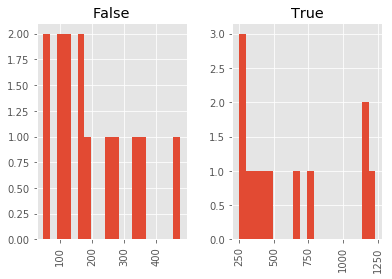

In [13]:
df[df.followers_count<400].hist(column='friends_count',bins = 20, by='isSearchingFollowers')

In [14]:
connex = {api.me().id: {'username': 'AlpoBM',
                        'friends_id':[i.id for i in followed], 
                        'friends_name':[i.name for i in followed],
                        'followers_id':[i.id for i in followers],
                        'followers_name':[i.name for i in followers]}}

In [15]:
for f in followers:
    ffo = f.followers()
    ffr = f.friends()
    connex[f.id] = {'username': f.name,
                    'friends_id':[i.id for i in ffr], 
                    'friends_name':[i.name for i in ffr],
                    'followers_id':[i.id for i in ffo],
                    'followers_name':[i.name for i in ffo]}

Rate limit reached. Sleeping for: 663


# Sandobx! Testing area

In [16]:
connex

{226662227: {'followers_id': [217078752,
   762703161048100866,
   754811821186486272,
   706098229360926721,
   742295084603969536,
   723850032672325633,
   3341973147,
   720002926148743171,
   419756520,
   4874510727,
   22246886,
   140023317,
   186161236,
   520878424,
   436729134,
   402947270,
   755311,
   2923535403,
   2425206039,
   446448502],
  'followers_name': ['Academias Unitec',
   'Juan Diaz Galindo',
   'salirenmalaga',
   'Cristina',
   'BigDataUMA',
   '.',
   'José Ángel Narváez',
   'Votante IndESIso',
   'muelleuno',
   'BTB Club',
   'Mr. Takox',
   'Jasucristo',
   'WMMR',
   'Traedme Pizza',
   'marilola jimenez',
   'Laura Almenara Oña',
   'Dani López 😬',
   'Lab School',
   'Orco de charca',
   'Jok7s'],
  'friends_id': [508553392,
   706098229360926721,
   723850032672325633,
   3341973147,
   186161236,
   140023317,
   22246886,
   520878424,
   3172232751,
   3346368821,
   402947270,
   160941691,
   1011987283,
   272434341,
   878171977,
   3618

In [17]:
#Let's store our exhaustive friends and followers lists:
friendList_raw = []
followersList_raw = []
for fri in tweepy.Cursor(api.friends).items():
    friendList_raw.append(fri)
for fol in tweepy.Cursor(api.followers).items():
    followersList_raw.append(fol)

In [18]:
len(friendList_raw)

61

In [19]:
len(followersList_raw)

57

In [20]:
nom = 'Dr. Alpo'

In [22]:
conAlpo = {1:{'username': nom,
           'followers_name': [i.name for i in followersList_raw],
           'friends_name': [i.name for i in friendList_raw]}}

In [23]:
conAlpo

{1: {'followers_name': ['BatvoiceTechnologies',
   'CEEIBIS',
   'yourwanderlust',
   'Acieh',
   'Amigos Ingeniería',
   'ViajesElCorteInglés',
   'Team Alpha Games',
   'kiara',
   'baobab',
   'Eric Invers Rubio',
   'Destrangis Indahouse',
   'pedro lozano',
   'Irene Sanz Vizcaíno',
   'Trii :)',
   'Karina',
   'Marta Rodriguez',
   'Bea Merino',
   'FiltroIdeal',
   'Yerhard Lalangui',
   'RevoltadelPOLITÒLEG',
   'Jeny',
   'ntnolmo',
   'Fertxupito',
   'Indefinido Bender',
   'Nicolás',
   'Euge',
   'Nuria',
   '~ artRaver ~',
   '★Aesthetics-MVP★',
   'BestFitnessWear',
   'Javier Snchz',
   '♛ SpanishFher ♛',
   'jordigiralde',
   'Josh F. #NoTincPor',
   'Albert Pierres',
   'Jonathan',
   'Toneman Ⓣ',
   'Sintomático',
   'Gerardology 🏊\u200d♂️',
   'big daddy',
   'A',
   'Alguien Diferente™',
   'Gabri',
   'Abel Trujillano',
   'Diego \uf8ff',
   'Perracko',
   'Iván Rodriguez',
   'Josué CG',
   'Arturo WT',
   'GranCanaria Coaching',
   'Manu Sáez',
   'Kojie',
   '